# EvCxR Jupyter Kernel チュートリアル

Jupyter Notebook や JupyterLab において、以下のボックスのような「セル」にコードを書き込むことができる

本テキストのように、セルにマークダウンを含めることも可能

各コードセルは個別にコンパイルおよび実行されるが、変数、定義された関数などはセル間で保持される

## 出力の表示、式の評価

標準出力（`stdout`）および標準エラー出力（`stderr`）を表示する

※ stdout と stderr は別のストリームであるため、必ずしも実行順通りには表示されないことに注意

In [2]:
// stdout に出力
println!("Hello, stdout!");

/**
 * stderr に出力
 * stdout, stderr は別ストリームのためどちらが先に表示されるかは不定
 */
eprintln!("Hello, stderr!");

Hello, stderr!


Hello, stdout!


Jupyter では、最後に評価された式の結果がアウトプットセルに表示される

ただし、セミコロンを後ろにつけてしまうと、式（`Expression`）ではなく文（`Statement`）として解釈されるため、何も返さない（アウトプットセルに何も表示されない）

In [3]:
// フォーマットされた文字列を返す（セミコロンなし: 式として評価）
format!("Hello {}!", "world")

"Hello world!"

In [4]:
// フォーマットされた文字列を返す（セミコロンあり: 文として実行）
format!("Hello {}!", "world");

## コメントについて

上記コードですでに出ているが、Rust では、`//...` で一行のコメント、`/* ... */` で複数行のコメントを記述することができる

コメント部分はプログラム上では一切解釈されないため、自由に記述して問題ない

## 変数の割り当てと利用

次の例では `message` という変数に文字列を割り当て、別のセルで処理を施した後、最終的に変数に割り当てられている文字列を表示する

Rust では、`let <変数名> = <値>` という宣言文で変数を宣言・値の割り当てを行うことができるが、デフォルトでは変数は immutable（不変）となっている

そのため、変数に対して処理を施したい場合や、別の値を再代入したい場合などは `let mut <変数名>` という宣言を行い、mutable（可変）変数を定義する

In [5]:
/**
 * message 変数を mutable で宣言し、"Hello " 文字列を割り当てる
 * 以下では String::from("Hello ") メソッドで文字列を生成しているが、単に "Hello " を渡した場合は文字列の参照（&str）となる
 */
let mut message = String::from("Hello ");

In [6]:
// message 変数に文字列 "world!" を追加
message.push_str("world!");

In [7]:
// message の中身を確認（セミコロンなし: 式として評価 => output cell に表示）
message

"Hello world!"

In [8]:
/**
 * 単に "Hello " を割り当てた場合は、push_str() メソッドでエラーが発生する
 * この場合 message 変数は "Hello " という文字列が存在するメモリ空間への参照（&str）が割り当てられているだけなので、文字列操作を行うことは出来ない
 */
let mut message = "Hello ";
message.push_str("world!");
message

Error: unused doc comment

Error: no method named `push_str` found for reference `&str` in the current scope

## 関数の定義・再定義

EvCxR では、関数を一度定義した後、関数の内容を修正したい場合、再定義を行うことが出来る

Rust の関数定義は `fn <関数名>([引数宣言]) [-> 戻り値の型] {<処理式>}` という形式で行われるが、デフォルトでは private 関数となり、スコープ外から呼び出すことは出来ない

public 関数として公開したい場合は `pub fn <関数名>(...) {...}`  のように `pub` キーワードを用いる

In [9]:
/// フィボナッチ数を返す関数（※ただし間違っている）
pub fn fib(x: i32) -> i32 {
    // Rust の関数は最後に評価された式の結果を戻り値として返す
    if x <= 2 {0} else {fib(x - 2) + fib(x - 1)}
}

// 1～13 の数列に対して fib 関数を適用し、配列（Vec）形式に変換
(1..13).map(fib).collect::<Vec<i32>>()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
/**
 * 上記の結果は間違っていたため、fib 関数を修正（再定義する）
 */
/// フィボナッチ数を返す関数
pub fn fib(x: i32) -> i32 {
    if x <= 2 {1} else {fib(x - 2) + fib(x - 1)}
}

(1..13).map(fib).collect::<Vec<i32>>()

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

## 外部クレートのロード

**クレート** とは Rust におけるコンパイルの単位

他の言語におけるライブラリやモジュールのようなものと考えれば良い

通常は **Cargo** パッケージマネージャを用いて外部クレートをインストールする必要があるが、EvCxR では `:dep <クレート名>` というマジックコマンドで外部クレートを呼び出すことが出来る

ただし、マジックコマンドの前に何らかの式や文、コメント等を入れてはならない（`:dep` マジックコマンドが Rust 式として解釈されてエラーとなる）

In [11]:
:dep base64 = "0.10.1"

// 上記マジックコマンドで base64: 0.10.1 クレートが使えるようになる
base64::encode(&vec![1, 2, 3, 4])

"AQIDBA=="

## Jupyter 表示のカスタマイズ

`evcxr_display` メソッドを継承することで、アウトプットセルの表示をカスタマイズすることができる

以下の例では、`Matrix` 構造体に `evcxr_display` メソッドを定義し、アウトプットセルで `<table>` HTML を表示できるようにしている

In [12]:
// std::fmt::Debug クレートを使う
use std::fmt::Debug;

// Matrix 構造体を定義
pub struct Matrix<T> {
    pub values: Vec<T>,
    pub row_size: usize
}

/**
 * Matrix構造体に共通のメソッド（トレイト）を定義
 * Rust はオブジェクト指向言語ではなく class はないが、特定の型に共通のふるまい（トレイト）を定義することで、より柔軟なオブジェクト指向風の実装が可能
 */
impl<T: Debug> Matrix<T> {
    /// evcxr_display: Jupyterアウトプットセルへの表示カスタマイズ
    pub fn evcxr_display(&self) {
        let mut html = String::from("<table>");
        for r in 0..(self.values.len() / self.row_size) {
            html.push_str("<tr>");
            for c in 0..self.row_size {
                html.push_str("<td>");
                html.push_str(&format!("{:?}", self.values[r * self.row_size + c]));
                html.push_str("</td>");
            }
            html.push_str("</tr>");
        }
        html.push_str("</table>");
        
        /**
         * 以下のような形式で出力することで Jupyter 上では HTML として出力できる
         *     EVCXR_BEGIN_CONTENT text/html
         *     ...(HTML content)
         *     EVCXR_END_CONTENT
         */
        println!("EVCXR_BEGIN_CONTENT text/html\n{}\nEVCXR_END_CONTENT", html);
    }
}

In [13]:
let m = Matrix {
    values: vec![1, 2, 3, 4, 5, 6, 7, 8, 9],
    row_size: 3
};

m

1,2,3
4,5,6
7,8,9


同様に、`evcxr_image` 等のアドオンクレートを使用して画像を表示することもできる

これにより RGB およびグレースケールの画像を Jupyter 上で表示できるようになる

※ 使用するクレートのバージョンは `evcxr_image` によって使用されるバージョンと一致する必要があることに注意（一致しない場合、型が実質的に異なり、イメージが表示されない）

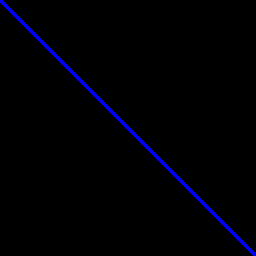

In [14]:
:dep image = "0.23"
:dep evcxr_image = "1.1"

use evcxr_image::ImageDisplay;

// 256 x 256 の画像を関数から作成
// Rust では `|[引数]| {<式>}` という形式で無名関数を定義できる
image::ImageBuffer::from_fn(256, 256, |x, y| {
    if (x as i32 - y as i32).abs() < 3 {
        image::Rgb([0, 0, 255])
    } else {
        image::Rgb([0, 0, 0])
    }
})

## 定義されている変数の表示

`:vars` マジックコマンドにより、定義済みの変数一覧を表示することが出来る

In [15]:
:vars

Variable,Type
m,Matrix<i32>
message,String


その他、使用可能なマジックコマンドは `:help` により確認することが出来る

In [16]:
:help

:clear,"Clear all state, keeping compilation cache"
:dep,"Add dependency. e.g. :dep regex = ""1.0"""
:efmt,Set the formatter for errors returned by ?
:explain,Print explanation of last error
:fmt,Set output formatter (default: {:?})
:help,Print command help
:internal_debug,Toggle various internal debugging code
:last_compile_dir,Print the directory in which we last compiled
:last_error_json,Print the last compilation error as JSON (for debugging)
:linker,"Set/print linker. Supported: system, lld"
:load_config,Reloads startup configuration files. Accepts optional flag `--quiet` to suppress logging.
